In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
import time
from statistics import mode

from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


In [2]:
#Read dataset made in EDA program
dat = pd.read_csv('https://raw.githubusercontent.com/ndelcamp/IST_718_Project/master/new_master.csv')
print(dat.columns)
display(dat.head())
print(dat.shape)

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation', 'CODE',
       'civilianFirearmsPer100Persons', 'region', 'subregion',
       'population2017', 'civilianFirearmsCount', 'computationMethod',
       'registeredFirearms', 'unregisteredFirearms', 'Country or Area',
       'InternetUsers', 'Population', 'Rank', 'Percentage', 'PercentRank'],
      dtype='object')


,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),...,civilianFirearmsCount,computationMethod,registeredFirearms,unregisteredFirearms,Country or Area,InternetUsers,Population,Rank,Percentage,PercentRank
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,...,350000.0,2,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,...,350000.0,2,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,...,350000.0,2,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,...,350000.0,2,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,...,350000.0,2,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75


(27820, 27)


In [64]:
#convert sex to sexf
def getSexF(s):
    if s == 'female':
        return(1)
    elif s == 'male':
        return(0)
    else:
        return(-9999)

dat['sexf'] = dat['sex'].apply(getSexF)
    
#convert age to agen (min age)
def getAge(a):
    a = a[:2]
    return(int(a.replace('-', '')))

dat['agen'] = dat['age'].apply(getAge)

dat.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),...,registeredFirearms,unregisteredFirearms,Country or Area,InternetUsers,Population,Rank,Percentage,PercentRank,sexf,agen
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,2156624900,...,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75,0,15
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,2156624900,...,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75,0,35
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,2156624900,...,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75,1,15
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,2156624900,...,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75,0,75
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,2156624900,...,65747.0,284253.0,Albania,2105339,2930187,117,0.7185,75,0,25


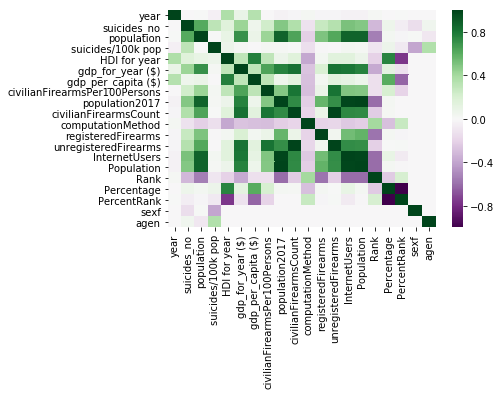

Index(['country', 'year', 'sex', 'age', 'suicides_no', 'population',
       'suicides/100k pop', 'country-year', 'HDI for year', 'gdp_for_year ($)',
       'gdp_per_capita ($)', 'generation', 'CODE',
       'civilianFirearmsPer100Persons', 'region', 'subregion',
       'population2017', 'civilianFirearmsCount', 'computationMethod',
       'registeredFirearms', 'unregisteredFirearms', 'Country or Area',
       'InternetUsers', 'Population', 'Rank', 'Percentage', 'PercentRank',
       'sexf', 'agen'],
      dtype='object')


In [65]:
#Correlation Matrix
corr = dat.corr()
sns.heatmap(corr, center = 0, cmap = 'PRGn')
plt.show()
print(dat.columns)

In [46]:
#Split into train/test
#Stratify by suicides/100k pop

datRF = dat.copy()

y = datRF['suicides/100k pop']
#Define binned value for stratification
y_percentile = pd.qcut(y, 4, labels=False)
datRF = datRF.drop(columns = ['suicides_no', 'suicides/100k pop', 'country-year', 'HDI for year', 'CODE', 'population2017', 
                              'computationMethod', 'Country or Area', 'Population', 'PercentRank', 'sexf', 'agen'])

datRF = datRF.select_dtypes(exclude = ['object'])

datRF = datRF.dropna(axis = 1)

X_train, X_test, y_train, y_test = train_test_split(datRF.values, y.values, stratify = y_percentile, test_size = 0.2, 
                                                   random_state = 1234)

for s in [X_train, X_test, y_train, y_test]:
    print(s.shape)

(22256, 9)
(5564, 9)
(22256,)
(5564,)


In [52]:
#Baseline MSE

y_avg = y_train.mean()
baseMSE = 0
maxE = 0
for y_ in range(len(y_test)):
    curE = abs(y_test[y_] - y_avg)
    baseMSE += curE ** 2
    if curE > maxE:
        maxE = curE
        print(y_)

baseMSE = baseMSE / len(y_test)

print('Baseline MSE: ' + str(baseMSE) + '\nMax Error: '+ str(maxE))

0
2
7
16
103
119
217
262
263
347
350
1336
1631
Baseline MSE: 365.6133751811941
Max Error: 212.12561960819554


In [60]:
dat.loc[dat['suicides/100k pop'] == y_test[1631]]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),...,civilianFirearmsCount,computationMethod,registeredFirearms,unregisteredFirearms,Country or Area,InternetUsers,Population,Rank,Percentage,PercentRank
1258,Aruba,1995,male,75+ years,2,889,224.97,Aruba1995,NaN,1320670391,...,3000.0,3,NaN,NaN,Aruba,102285,105264,176,0.9717,9


In [10]:
#Get all possible combinations of keep list
import itertools
combs = []
for L in range(1, len(datRF.columns)):
    for subset in itertools.combinations(datRF.columns, L):
        combs.append(subset)

len(combs)

510

In [11]:
#Mega loop: loop through variable combinations to find best ones.
 
#Test all combinations of variables with Random Forest Model
varskept = []
bestParam = []
bestScore = []
testError = []

for comb in combs:
    tmplist = [v for v in comb]
    tmpdat = datRF[tmplist]
    X_train, X_test, y_train, y_test = train_test_split(tmpdat.values, y.values, stratify = y_percentile, 
                                                        test_size = 0.2, random_state = 1234)
    
    random_forest = RandomForestRegressor(n_estimators=100)
    rf_param_grid = {'max_depth': [3, 7, 12, 16, 24], 
                     'max_features': ['auto', 'log2', 0.15, None]}

    rf_gridsearch = GridSearchCV(cv = 3, estimator = random_forest, param_grid = rf_param_grid, 
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)
    rf_gridsearch.fit(X_train, y_train)
    
    varskept.append(tmplist)
    bestParam.append(rf_gridsearch.best_params_)
    bestScore.append(rf_gridsearch.best_score_)
    
    y_pred = rf_gridsearch.predict(X_test)
    testError.append(mean_squared_error(y_test, y_pred))


In [15]:
goodvars = varskept[testError.index(min(testError))]
goodParam = bestParam[testError.index(min(testError))]

print(bestScore[testError.index(min(testError))])
print(testError[testError.index(min(testError))])
print(goodvars)
print(goodParam)

-130.1168228677825
136.6103802358348
['year', 'population', 'civilianFirearmsPer100Persons', 'civilianFirearmsCount', 'InternetUsers', 'Rank', 'Percentage']
{'max_depth': 16, 'max_features': 'auto'}


In [26]:
#Use new knowledge to create final model

random_forest = RandomForestRegressor(n_estimators=100)

X_train, X_test, y_train, y_test = train_test_split(datRF[goodvars].values, y.values, stratify = y_percentile, 
                                                    test_size = 0.2, random_state = 1234)

finalRF = RandomForestRegressor(n_estimators = 100, max_depth = 16, max_features = 'auto')
finalRF.fit(X_train, y_train)
finalRF.fit(X_train, y_train)
y_pred = finalRF.predict(X_test)
mean_squared_error(y_test, y_pred)


137.52321261725675

In [29]:
#See some predictions
for y in range(len(y_test)):
    print(str(y_test[y]) + '---' + str(y_pred[y]))

6.63---2.160321936267562
16.89---13.104824625255274
36.66---34.2050350869046
4.98---6.088911375611526
34.11---17.7965822622079
24.88---17.020591271962008
16.72---22.95395782236329
52.19---21.05084997536028
6.93---13.056944422767529
0.0---0.1966626276704325
0.0---0.15279066193853427
11.02---5.007739905499818
1.96---5.226708914985079
27.03---9.131525457904246
12.08---27.484142407392355
7.9---12.089024514174303
54.76---27.442817300054898
5.74---5.707308363678806
7.62---1.9814642808359975
8.05---13.400355341615331
0.82---5.09116615827994
3.37---19.772141511038978
2.01---5.646275565935873
17.23---6.488214648148162
7.92---7.031410932639326
23.34---11.664817318606849
8.81---4.701533782415001
13.44---15.250088095238093
5.0---4.439392409620525
6.1---2.7713395163255297
0.0---2.6402512586730165
0.65---3.6091182917574054
0.66---6.695887577609586
3.39---3.849169902037533
22.71---10.76871948905417
1.12---3.6472395778891196
0.19---1.2602281723125928
25.84---23.69201124134208
0.25---1.3757254527664942

0.0---3.0114843992234785
8.7---7.180733911884426
44.64---14.813739250161596
4.63---3.8538992647118926
8.51---24.000430855855846
0.0---12.219396381312094
0.8---3.26653224422784
13.57---16.40365906589874
0.0---2.8317547230919438
0.0---1.3725999999999998
25.36---10.06015463972043
25.02---19.559714629546406
1.05---2.0364223666608434
2.14---11.747524366260294
1.0---2.526239001123177
3.41---5.147645865122611
51.54---39.70395891604981
13.85---9.642915185994902
17.44---12.93567605213479
0.0---0.4635684272332074
11.42---21.0331305390627
0.0---0.7699061989032719
15.11---10.725360691183278
1.13---1.188580355675283
11.49---3.3322445911599674
1.43---10.490907915648979
45.99---32.549292986493874
0.0---1.6459431832835787
7.98---6.21820237124771
0.75---1.2473408015416911
0.0---0.9070944847237381
10.02---7.353670988020326
0.0---5.994812404364476
46.54---46.717799999999926
0.86---0.8395775083491067
7.43---0.8757010633810636
4.09---4.1461108719069735
2.41---8.667361799901308
7.56---20.50792332954014
31.3

7.41---7.806258812172103
73.65---9.08459414905891
0.49---5.4513281679536325
0.0---3.4455330827672204
17.07---12.818900980940054
9.47---27.661720995463398
22.96---21.320416944477593
7.73---16.95962123347704
21.61---12.253417130297587
7.42---9.019031969566715
7.08---7.652755610529225
21.14---12.976751433206134
20.53---22.257191817504594
7.33---19.111174241659704
11.95---7.680176006699635
0.0---1.0781233510332635
0.0---2.512814592741693
0.0---2.931533518035637
7.38---5.902301038903005
18.78---12.942252931929636
11.42---14.988168022140458
12.27---5.777148170824074
2.69---4.085373262277826
2.3---2.00247282992206
1.22---1.839693943742289
0.3---1.2362501160868389
2.1---13.437430790304361
0.24---1.3752353081908189
33.95---21.128406891213835
6.76---10.606728114792176
19.1---7.757208571428567
20.19---9.642537376423583
1.97---31.420021726923757
0.99---10.607037507570956
10.99---12.863334155996766
6.06---15.927755843596586
4.88---14.271123355668918
16.84---10.995527835196269
2.22---5.9488464497387

3.57---2.6747291284003465
5.89---16.527706900485313
12.89---3.2321996597589684
4.46---16.89727433117862
2.84---5.040045473380287
10.67---51.13406595039019
1.14---0.7410056122395611
8.35---12.567275425442824
0.0---2.6999529575601775
1.1---6.749963709792796
17.55---9.785033136472661
0.0---8.52332946767866
15.48---3.25233534110088
7.72---7.402201634199144
10.75---5.799216800658847
22.9---9.061853553296256
0.49---5.645247573846095
10.5---18.507529419066586
23.3---19.597007619761758
2.43---3.2562389356098516
30.5---20.9477034750405
0.0---0.2557142714683677
25.4---19.642860742509466
3.4---10.663260314889119
0.65---1.832608333206014
0.19---3.092632218774495
0.0---0.0
150.0---61.181712500000025
20.36---23.160078429871465
6.06---28.037206251591545
0.0---0.0
2.75---7.328486385425975
2.33---9.37147853780693
20.75---13.167792602884438
37.1---33.60170864814354
0.27---7.9474333641277815
38.95---23.22817942433385
4.85---5.184313514840806
0.34---2.7142331851350656
4.0---8.728921208522035
0.71---5.0307

1.79---6.608501460443442
15.62---69.61733047792895
8.2---11.204904474971197
13.94---19.72267153355231
4.19---7.941784779551308
13.13---6.947905571116904
5.6---18.96732127114854
6.3---5.222257719156029
10.78---8.332318287987553
8.7---12.951979709841817
8.81---0.6818442583732058
9.17---13.586969227463367
7.06---3.671265706444097
0.59---7.129731748901685
6.77---14.018633441904546
2.1---5.15484535095051
1.32---10.841277295373619
0.2---5.105344697408633
25.54---23.06480271343246
0.19---5.437071687899557
8.85---12.364536851580164
19.41---17.206972810489464
81.48---89.04703472222224
16.09---18.073861109609144
4.46---4.143614594430156
1.88---3.3072693720367345
59.48---50.14674157142865
18.63---11.015090335792326
19.95---22.27485528792307
0.0---6.812083388777977
0.0---7.717965700679809
7.23---13.208404254254852
0.44---4.763889842562311
13.11---3.2064814711419887
6.82---17.55220936735237
14.82---13.529217269567415
0.0---0.10455587912087912
0.0---0.1105114295887518
0.0---2.6014334451605015
13.19-

In [59]:
#Calculate MSE again (sanity check) and the max error

mse = 0
maxError = 0
for y in range(len(y_test)):
    curE = abs(y_test[y] - y_pred[y])
    mse += curE ** 2
    if curE > maxError:
        maxError = curE
        print(str(y) + ': ' + str(y_test[y]) + '===' + str(y_pred[y]))

mse = mse / len(y_test)

print('MSE: ' + str(mse) + '\nMax Error: '+ str(maxError))

0: 6.63===2.160321936267562
4: 34.11===17.7965822622079
7: 52.19===21.05084997536028
41: 41.47===7.612136095026447
56: 49.8===13.267101928135833
79: 7.26===57.8384724343138
263: 95.74===26.09912992798109
405: 84.61===9.533410655302944
1336: 204.92===12.233896626794257
MSE: 137.52321261725692
Max Error: 192.68610337320573


In [57]:
dat.loc[dat['suicides/100k pop'] == y_test[1336]]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),...,civilianFirearmsCount,computationMethod,registeredFirearms,unregisteredFirearms,Country or Area,InternetUsers,Population,Rank,Percentage,PercentRank
22280,Seychelles,2006,male,75+ years,2,976,204.92,Seychelles2006,NaN,1016418229,...,4000.0,2,NaN,NaN,Seychelles,55677,94737,191,0.5877,107


In [66]:
#Split into train/test
#Stratify by suicides/100k pop

datRF = dat.copy()

y = datRF['suicides/100k pop']
#Define binned value for stratification
y_percentile = pd.qcut(y, 4, labels=False)
datRF = datRF.drop(columns = ['suicides_no', 'suicides/100k pop', 'country-year', 'HDI for year', 'CODE', 'population2017', 
                              'computationMethod', 'Country or Area', 'Population', 'PercentRank'])

datRF = datRF.select_dtypes(exclude = ['object'])

datRF = datRF.dropna(axis = 1)

X_train, X_test, y_train, y_test = train_test_split(datRF.values, y.values, stratify = y_percentile, test_size = 0.2, 
                                                   random_state = 1234)

for s in [X_train, X_test, y_train, y_test]:
    print(s.shape)

(22256, 11)
(5564, 11)
(22256,)
(5564,)


In [72]:
#Get variables to keep
keep = ['year', 'population', 'civilianFirearmsPer100Persons', 'civilianFirearmsCount', 'InternetUsers', 
        'Rank', 'Percentage', 'sexf', 'agen']


In [82]:
#Get best parameters for keep vars

random_forest = RandomForestRegressor(n_estimators=100)
rf_param_grid = {'max_depth': [18, 24, 28, 36], 
                 'max_features': ['auto', 'log2', 0.15, None]}

rf_gridsearch = GridSearchCV(cv = 3, estimator = random_forest, param_grid = rf_param_grid, 
                             scoring = 'neg_mean_squared_error', n_jobs = -1)

rf_gridsearch.fit(X_train, y_train)

print(rf_gridsearch.best_params_)
print(rf_gridsearch.best_score_)

y_pred = rf_gridsearch.predict(X_test)
print(mean_squared_error(y_test, y_pred))


{'max_depth': 24, 'max_features': 'log2'}
-34.86410880426378
48.45571286159907


In [77]:
#See some predictions
for y in range(len(y_test)):
    print('True: ' + str(y_test[y]) + ' --- ' + 'Pred: ' + str(y_pred[y]))

True: 6.63 --- Pred: 2.8543952380952398
True: 16.89 --- Pred: 16.6773145787546
True: 36.66 --- Pred: 34.251948333333374
True: 4.98 --- Pred: 4.677985000000001
True: 34.11 --- Pred: 22.331650000000018
True: 24.88 --- Pred: 25.25494434065932
True: 16.72 --- Pred: 14.985513571428578
True: 52.19 --- Pred: 47.80490000000003
True: 6.93 --- Pred: 5.314899300699299
True: 0.0 --- Pred: 0.43479999999999996
True: 0.0 --- Pred: 0.2674
True: 11.02 --- Pred: 11.802832503156456
True: 1.96 --- Pred: 2.557697083458345
True: 27.03 --- Pred: 27.879015448823196
True: 12.08 --- Pred: 13.311748397435897
True: 7.9 --- Pred: 5.915399999999996
True: 54.76 --- Pred: 48.65970000000003
True: 5.74 --- Pred: 5.892773333333333
True: 7.62 --- Pred: 1.8440000000000012
True: 8.05 --- Pred: 9.600900000000001
True: 0.82 --- Pred: 0.8748176470588231
True: 3.37 --- Pred: 6.723500000000004
True: 2.01 --- Pred: 0.5863555555555555
True: 17.23 --- Pred: 19.842999999999996
True: 7.92 --- Pred: 8.740095451025935
True: 23.34 --- 

True: 0.0 --- Pred: 3.3462
True: 3.84 --- Pred: 3.090153643737311
True: 3.51 --- Pred: 2.186426636190606
True: 29.52 --- Pred: 33.57145771413922
True: 10.93 --- Pred: 24.968100000000007
True: 30.02 --- Pred: 31.29661165266106
True: 35.79 --- Pred: 36.14410000000004
True: 0.42 --- Pred: 2.203241666666666
True: 6.73 --- Pred: 6.974706666666667
True: 0.49 --- Pred: 0.4590593804553885
True: 21.07 --- Pred: 18.69029999999998
True: 7.61 --- Pred: 6.933333333333329
True: 16.46 --- Pred: 18.576500000000003
True: 4.98 --- Pred: 0.09910000000000001
True: 2.24 --- Pred: 2.531721818181821
True: 36.01 --- Pred: 34.0713375
True: 7.82 --- Pred: 9.015046666666668
True: 8.5 --- Pred: 9.77525253968253
True: 34.43 --- Pred: 26.87359743589743
True: 0.0 --- Pred: 3.9855000000000014
True: 21.17 --- Pred: 19.59728091991342
True: 0.0 --- Pred: 12.132900000000006
True: 2.9 --- Pred: 3.8120333333333334
True: 14.33 --- Pred: 13.536523787878785
True: 1.64 --- Pred: 1.5209000000000008
True: 10.11 --- Pred: 11.5809

True: 0.43 --- Pred: 1.3881119047619046
True: 0.14 --- Pred: 0.0863
True: 1.5 --- Pred: 3.0772301377290345
True: 8.82 --- Pred: 8.814371153846157
True: 25.74 --- Pred: 15.678599999999996
True: 9.37 --- Pred: 7.171395238095249
True: 6.03 --- Pred: 7.091250000000006
True: 4.96 --- Pred: 1.0766999999999998
True: 6.5 --- Pred: 6.815200000000002
True: 1.26 --- Pred: 1.2217707575757581
True: 2.04 --- Pred: 1.97205
True: 12.02 --- Pred: 11.54979999999999
True: 7.03 --- Pred: 0.8072
True: 17.14 --- Pred: 15.685500000000022
True: 15.77 --- Pred: 16.386221107291405
True: 27.06 --- Pred: 12.375100000000005
True: 2.67 --- Pred: 1.8391860132748763
True: 15.65 --- Pred: 10.155999999999999
True: 0.5 --- Pred: 0.14313440285204992
True: 20.29 --- Pred: 21.131799999999995
True: 64.15 --- Pred: 63.65686666666673
True: 6.46 --- Pred: 14.23486249999999
True: 28.53 --- Pred: 13.034768253968252
True: 37.39 --- Pred: 36.6575
True: 23.73 --- Pred: 24.32195320512821
True: 48.92 --- Pred: 49.916985714285744
True

True: 8.14 --- Pred: 9.138192051282054
True: 13.07 --- Pred: 13.691284999999988
True: 27.29 --- Pred: 25.440299999999993
True: 2.7 --- Pred: 1.5466999999999995
True: 8.01 --- Pred: 6.601049166666671
True: 1.47 --- Pred: 0.5852935278413421
True: 4.03 --- Pred: 4.499566904761901
True: 4.97 --- Pred: 6.701175000000001
True: 0.99 --- Pred: 0.47992832010581987
True: 0.35 --- Pred: 0.41652500000000037
True: 4.35 --- Pred: 4.410278541758884
True: 17.02 --- Pred: 18.774687301587313
True: 5.63 --- Pred: 6.728411764705877
True: 0.29 --- Pred: 0.17510075757575763
True: 6.08 --- Pred: 8.151985714285713
True: 5.41 --- Pred: 4.277100000000003
True: 44.2 --- Pred: 33.833742857142894
True: 0.0 --- Pred: 0.6579999999999999
True: 60.0 --- Pred: 2.4684
True: 0.3 --- Pred: 0.47346666666666715
True: 0.0 --- Pred: 6.554881818181815
True: 17.72 --- Pred: 17.272624999999998
True: 2.02 --- Pred: 2.404500000000001
True: 0.0 --- Pred: 0.2408
True: 63.92 --- Pred: 58.03250000000002
True: 23.17 --- Pred: 22.651699

True: 16.9 --- Pred: 14.073999999999996
True: 4.09 --- Pred: 3.818500000000004
True: 0.0 --- Pred: 0.0
True: 13.13 --- Pred: 14.217857142857149
True: 11.56 --- Pred: 11.296570238095228
True: 78.17 --- Pred: 62.60989999999995
True: 0.0 --- Pred: 0.35969999999999996
True: 2.38 --- Pred: 6.01260476190477
True: 0.0 --- Pred: 5.1338
True: 1.32 --- Pred: 3.1064500000000015
True: 11.47 --- Pred: 11.692827
True: 6.36 --- Pred: 4.536264285714284
True: 1.06 --- Pred: 7.551400000000001
True: 95.84 --- Pred: 89.87970000000001
True: 6.51 --- Pred: 5.45765
True: 28.57 --- Pred: 27.664999999999992
True: 23.58 --- Pred: 24.366900000000008
True: 5.63 --- Pred: 5.583511904761907
True: 8.64 --- Pred: 7.786099999999992
True: 0.0 --- Pred: 0.1116
True: 8.27 --- Pred: 7.6009500000000045
True: 22.04 --- Pred: 19.392699999999987
True: 0.0 --- Pred: 1.7013249999999998
True: 5.89 --- Pred: 6.443099733893551
True: 1.8 --- Pred: 2.216254999999999
True: 17.24 --- Pred: 19.5762
True: 3.77 --- Pred: 4.02779999999999

True: 6.02 --- Pred: 7.429369791666666
True: 3.07 --- Pred: 6.693200000000006
True: 0.49 --- Pred: 0.8211671371610848
True: 12.49 --- Pred: 11.910999999999996
True: 15.02 --- Pred: 15.010229051781558
True: 45.04 --- Pred: 44.52051851851857
True: 10.38 --- Pred: 9.580649999999997
True: 13.15 --- Pred: 22.777752380952375
True: 1.0 --- Pred: 1.0664000000000005
True: 0.1 --- Pred: 0.39254252259436456
True: 12.75 --- Pred: 8.747233333333334
True: 1.35 --- Pred: 1.2033033333333334
True: 14.7 --- Pred: 17.759449999999994
True: 18.79 --- Pred: 15.8468
True: 12.85 --- Pred: 13.788499999999985
True: 30.67 --- Pred: 28.739457857142867
True: 18.65 --- Pred: 15.478399999999999
True: 9.7 --- Pred: 9.183599999999993
True: 5.53 --- Pred: 7.62484283216782
True: 0.0 --- Pred: 33.491500000000016
True: 32.3 --- Pred: 33.490639999999985
True: 33.95 --- Pred: 33.34384290293038
True: 4.04 --- Pred: 5.009326923076923
True: 7.92 --- Pred: 8.886499999999995
True: 0.88 --- Pred: 1.0812000000000008
True: 4.88 ---

True: 35.77 --- Pred: 35.24100000000004
True: 0.0 --- Pred: 2.0771999999999995
True: 24.28 --- Pred: 23.279046986470462
True: 9.76 --- Pred: 8.709399999999993
True: 0.0 --- Pred: 0.15699999999999995
True: 0.0 --- Pred: 0.0
True: 7.9 --- Pred: 9.466370000000007
True: 3.94 --- Pred: 4.689411908848199
True: 0.74 --- Pred: 2.017331159420294
True: 22.67 --- Pred: 21.609900000000003
True: 39.54 --- Pred: 35.21002908496732
True: 14.94 --- Pred: 14.903900000000007
True: 5.52 --- Pred: 7.805255555555553
True: 2.1 --- Pred: 3.0786969959677424
True: 1.78 --- Pred: 6.790733333333336
True: 3.98 --- Pred: 3.282268571428572
True: 13.63 --- Pred: 12.985732117882126
True: 50.97 --- Pred: 49.900137500000056
True: 0.82 --- Pred: 1.2169764537852918
True: 40.43 --- Pred: 49.520800000000044
True: 29.2 --- Pred: 22.294099999999993
True: 0.0 --- Pred: 3.6365
True: 2.69 --- Pred: 2.8731786551239997
True: 17.3 --- Pred: 12.56199228632478
True: 0.0 --- Pred: 3.8273999999999986
True: 0.84 --- Pred: 0.605061111111

In [91]:
#Calculate MSE again (sanity check) and the max error

mse = 0
maxError = 0
for y in range(len(y_test)):
    curE = abs(y_test[y] - y_pred[y])
    mse += curE ** 2
    if curE > maxError:
        maxError = curE
        print(str(y) + ': ' + str(y_test[y]) + '===' + str(y_pred[y]) + '===' + str(curE))

mse = mse / len(y_test)

print('MSE: ' + str(mse) + '\nMax Error: '+ str(maxError))

0: 6.63===3.0152000000000005===3.6147999999999993
4: 34.11===18.979383333333338===15.130616666666661
41: 41.47===22.445399999999985===19.024600000000014
56: 49.8===18.50249999999999===31.297500000000007
394: 85.41===43.02589999999999===42.384100000000004
1336: 204.92===5.845100000000001===199.07489999999999
1631: 224.97===15.540400000000002===209.4296
MSE: 48.45571286159905
Max Error: 209.4296


In [86]:
dat.loc[dat['suicides/100k pop'] == y_test[1631]]

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),...,registeredFirearms,unregisteredFirearms,Country or Area,InternetUsers,Population,Rank,Percentage,PercentRank,sexf,agen
1258,Aruba,1995,male,75+ years,2,889,224.97,Aruba1995,NaN,1320670391,...,NaN,NaN,Aruba,102285,105264,176,0.9717,9,0,75
